In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import and_, create_engine, text, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [12]:
most_recent_date = dt.date(2017, 8, 23)
most_recent_date

datetime.date(2017, 8, 23)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [17]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).filter(and_(measurement.date >= year_ago, measurement.date <= most_recent_date))
data = query.all()

precipitation_data = [{"date": d[0], "precipitation": d[1]} for d in data]


In [18]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.head()


,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [20]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df = precipitation_df.reset_index(drop=True)
precipitation_df = precipitation_df.dropna()
precipitation_df


,date,precipitation
0,2016-08-23,0.00
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15
5,2016-08-23,0.70
...,...,...
2225,2017-08-22,0.00
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


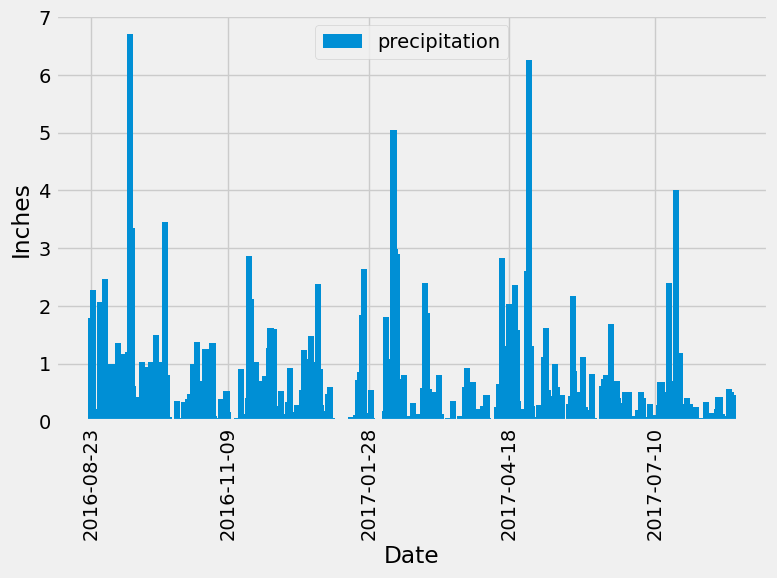

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data

#create evenly spaced date ranges for x-ticks
start_date = precipitation_df['date'].min()
end_date = precipitation_df['date'].max()
evenly_spaced_dates = pd.date_range(start_date, end_date, periods=5)

plt.figure(figsize=(8, 6))
plt.bar(precipitation_df['date'], precipitation_df['precipitation'], width=3.5, label="precipitation")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')

xtick_positions = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
xtick_labels = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(xtick_positions, xtick_labels, rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(measurement.station).distinct().count()
total_stations

9

In [25]:
active_stations = session.query(
    measurement.station,
    func.count(measurement.station).label('station_count')).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)]

most_active_station = session.query(*sel).\
    filter(measurement.station == 'USC00519281').all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
station_query = session.query(measurement.date, measurement.tobs).filter(and_(measurement.date >= year_ago, measurement.date <= most_recent_date))
data = station_query.\
    filter(measurement.station == 'USC00519281').all()

active_station_data = [d[1] for d in data]

In [28]:
#put into dataframe
active_station_df = pd.DataFrame(active_station_data, columns=['Temperature'])
active_station_df

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


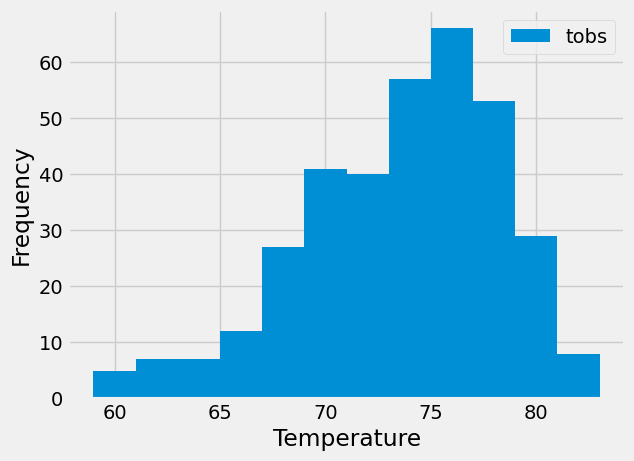

In [29]:
#plot the results as a histogram
plt.hist(active_station_df, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.show()

# Close Session

In [30]:
# Close Session
session.close()